In [159]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [3]:
movdf_norm = pd.read_csv("movdf_norm.csv")

In [160]:
movdf_norm.head()

,Unnamed: 0,Unnamed: 0.1,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens,tokenized_sents,normalized_sents
0,0,3547424,Goodbye to All That,"Short, Musical",1930,English,290635,"['In', 'the', 'future', 'a', 'computer', 'prog...","@3547424 In the future , a computer program ca...",35320,"['future', 'computer', 'program', 'called', 's...","[[@3547424, In, the, future, a, computer, prog...","[[@3547424, future, computer, program, called,..."
1,1,3660608,Abraham Lincoln,"Biography, Drama, History",1930,English,20620,"['Tom', 'Lincoln', 'It', ""'s"", 'a', 'comin', '...",@3660608 Tom Lincoln ! It's a comin ' - Boy or...,49770,"['tom', 'lincoln', 'comin', 'boy', 'gal', 't',...","[[@3660608, Tom, Lincoln], [It, 's, a, comin, ...","[[@3660608, tom, lincoln], [comin, boy, gal], ..."
2,2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...,69596,"['russians', 'french', 'russians', 'capture', ...","[[@60053, Thirty, thousand], [], [From, the, R...","[[@60053], [], [russians], [french], [russians..."
3,3,3435788,Born Reckless,"Crime, Drama, Film-Noir",1930,"English, Italian, French",20702,"['Louis', 'Louis', 'Beretti', 'Shh', 'Put', 't...",@3435788 Louis ? Louis ? - Beretti ? - Shh ! P...,49565,"['louis', 'louis', 'beretti', 'shh', 'sap', 'k...","[[@3435788, Louis], [Louis], [Beretti], [Shh],...","[[@3435788, louis], [louis], [beretti], [shh],..."
4,4,6922578,King of Jazz,"Animation, Music",1930,English,21025,"['Music', 'hath', 'charms', 'that', 'nothing',...",@6922578 Music hath charms that nothing else h...,33966,"['music', 'hath', 'charms', 'music', 'hath', '...","[[@6922578, Music, hath, charms, that, nothing...","[[@6922578, music, hath, charms, music, hath, ..."


In [9]:
#Apply our functions, notice each row is a list of lists now
movdf_norm['tokenized_sents'] = movdf_norm['Text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
movdf_norm['normalized_sents'] = movdf_norm['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [11]:
movdf_norm.to_csv("movdf_normsent.csv")

In [12]:
movdf_normW2V = gensim.models.word2vec.Word2Vec(movdf_norm['normalized_sents'].sum())

In [13]:
movdf_normW2V.most_similar('woman')

[('man', 0.7032180428504944),
 ('girl', 0.6733739972114563),
 ('lady', 0.6535834074020386),
 ('women', 0.6522245407104492),
 ('person', 0.6161810755729675),
 ('teenager', 0.61060631275177),
 ('wife', 0.6089967489242554),
 ('sexually', 0.5852789878845215),
 ('prostitute', 0.5762177109718323),
 ('child', 0.576163113117218)]

In [16]:
movdf_normW2V.most_similar(positive=['woman', 'women', 'girl', 'girls'], negative = ['man'])

[('teenagers', 0.604285717010498),
 ('babies', 0.5993967652320862),
 ('teenager', 0.5972654819488525),
 ('couples', 0.5925687551498413),
 ('boys', 0.5920388698577881),
 ('mothers', 0.5641217231750488),
 ('kids', 0.5634639859199524),
 ('children', 0.5613487362861633),
 ('wives', 0.5611754059791565),
 ('husbands', 0.5593338012695312)]

In [17]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [21]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [18]:
mov_war = movdf_norm[movdf_norm['Genre'].str.contains('War', na=False)] #114 movies

In [19]:
mov_war.head()

,Unnamed: 0,Unnamed: 0.1,Movie Name,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens,tokenized_sents,normalized_sents
2,2,60053,All Quiet on the Western Front,"Drama, War",1930,"English, French, German, Latin",20629,"['Thirty', 'thousand', 'From', 'the', 'Russian...",@60053 - Thirty thousand . - From the Russians...,69596,"['russians', 'french', 'russians', 'capture', ...","[[@60053, Thirty, thousand], [], [From, the, R...","[[@60053], [], [russians], [french], [russians..."
17,17,6880640,Dishonored,"Drama, Romance, War",1931,English,21800,"['I', 'thought', 'I', 'smelled', 'gas', 'That'...",@6880640 I thought I smelled gas . That's thre...,26660,"['thought', 'smelled', 'gas', 'year', 'decency...","[[@6880640, I, thought, I, smelled, gas], [Tha...","[[@6880640, thought, smelled, gas], [year], [d..."
55,55,181172,The Bitter Tea of General Yen,"Drama, Romance, War",1932,"English, Mandarin, French",23814,"['Well', 'if', 'it', 'is', ""n't"", 'Amelia', 'o...","@181172 Well , if it isn't Amelia , our little...",52331,"['amelia', 'little', 'tower', 'strength', 'tie...","[[@181172], [Well, if, it, is, n't, Amelia, ou...","[[@181172], [amelia, little, tower, strength, ..."
76,76,5801900,Forgotten Men,"Documentary, War",1933,English,150614,"['When', 'British', 'International', 'Pictures...",@5801900 When British International Pictures o...,51957,"['british', 'international', 'pictures', 'offe...","[[@5801900], [When, British, International, Pi...","[[@5801900], [british, international, pictures..."
77,77,3498365,Heroes for Sale,"Drama, War",1933,"English, German",24115,"['These', 'three', 'shell', 'holes', 'are', '1...",@3498365 These three shell holes are 1 o feet ...,57459,"['shell', 'holes', 'o', 'feet', 'apart', 'spli...","[[@3498365, These, three, shell, holes, are, 1...","[[@3498365, shell, holes, o, feet, apart], [sp..."


In [23]:
import networkx as nx

For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify them). Rendering words linked as a network or discrete topology allows us to take advantage of the network analysis metrics like centrality and community.

In [41]:
is_1930s =  movdf_norm['Year'].isin(["1930", "1931","1932", "1933", "1934", "1935", "1936", "1937", "1938", "1939"])
only_1930s = movdf_norm[is_1930s]

is_2010s =  movdf_norm['Year'].isin(["2010", "2011","2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019"])
only_2010s = movdf_norm[is_2010s]

# Getting a subset of movies for the decades

In [50]:
only30s_50 = only_1930s[:50]
only10s_50 = only_2010s[:50]

In [43]:
mov_romance = movdf_norm[movdf_norm['Genre'].str.contains('Romance', na=False)] #114 movies
mov_drama = movdf_norm[movdf_norm['Genre'].str.contains('Drama', na=False)] #114 movies
mov_comedy = movdf_norm[movdf_norm['Genre'].str.contains('Comedy', na=False)] #114 movies
mov_horror = movdf_norm[movdf_norm['Genre'].str.contains('Horror', na=False)] #114 movies
mov_scifi = movdf_norm[movdf_norm['Genre'].str.contains('Sci-Fi', na=False)] #114 movies
mov_sport = movdf_norm[movdf_norm['Genre'].str.contains('Sport', na=False)] #114 movies
mov_war = movdf_norm[movdf_norm['Genre'].str.contains('War', na=False)] #114 movies

# NOUN VERB RELATIONSHIPS

# 1930 NV Relationships

In [51]:
gNV_30s = posCooccurrence(only30s_50['normalized_sents'].sum(), 'NN', 'VB')

In [56]:
gNV_30s.remove_edges_from([(n1,n2) for n1,n2,d in gNV_30s.edges(data = True) if gNV_30s.nodes[n1]['bipartite'] == gNV_30s.nodes[n2]['bipartite']])

In [57]:
g_womanNV30 = gNV_30s.subgraph(['woman'] + list(gNV_30s.neighbors('woman')))

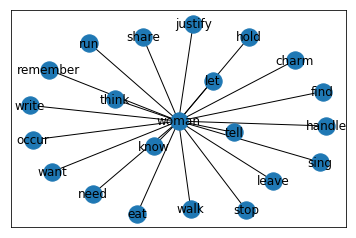

In [58]:
nx.draw_networkx(g_womanNV30)

In [81]:
g_girlNV30 = gNV_30s.subgraph(['girl'] + list(gNV_30s.neighbors('girl')))

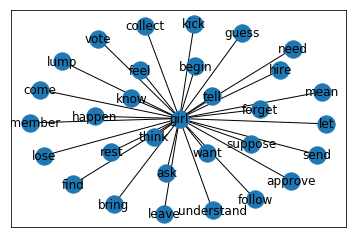

In [82]:
nx.draw_networkx(g_girlNV30)

In [59]:
g_manNV30 = gNV_30s.subgraph(['man'] + list(gNV_30s.neighbors('man')))

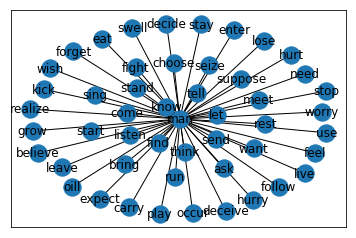

In [60]:
nx.draw_networkx(g_manNV30)

In [83]:
g_boyNV30 = gNV_30s.subgraph(['boy'] + list(gNV_30s.neighbors('boy')))

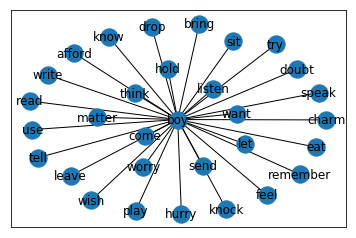

In [84]:
nx.draw_networkx(g_boyNV30)

In [61]:
sorted(nx.degree_centrality(g_manNV30).items(), key = lambda x: x[1], reverse = True)[:10]

[('man', 0.9999999999999999),
 ('tell', 0.02040816326530612),
 ('enter', 0.02040816326530612),
 ('find', 0.02040816326530612),
 ('hurry', 0.02040816326530612),
 ('feel', 0.02040816326530612),
 ('send', 0.02040816326530612),
 ('worry', 0.02040816326530612),
 ('suppose', 0.02040816326530612),
 ('follow', 0.02040816326530612)]

In [62]:
sorted(nx.eigenvector_centrality(g_manNV30).items(), key = lambda x: x[1], reverse = True)[:10]

[('man', 0.7071090311729852),
 ('tell', 0.10101493302756438),
 ('enter', 0.10101493302756438),
 ('find', 0.10101493302756438),
 ('hurry', 0.10101493302756438),
 ('feel', 0.10101493302756438),
 ('send', 0.10101493302756438),
 ('worry', 0.10101493302756438),
 ('suppose', 0.10101493302756438),
 ('follow', 0.10101493302756438)]

In [64]:
sorted(nx.degree_centrality(g_womanNV30).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 1.0),
 ('tell', 0.047619047619047616),
 ('find', 0.047619047619047616),
 ('handle', 0.047619047619047616),
 ('walk', 0.047619047619047616),
 ('occur', 0.047619047619047616),
 ('sing', 0.047619047619047616),
 ('remember', 0.047619047619047616),
 ('know', 0.047619047619047616),
 ('need', 0.047619047619047616)]

In [65]:
sorted(nx.eigenvector_centrality(g_womanNV30).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 0.7071079569156934),
 ('tell', 0.1543030933965316),
 ('find', 0.1543030933965316),
 ('handle', 0.1543030933965316),
 ('walk', 0.1543030933965316),
 ('occur', 0.1543030933965316),
 ('sing', 0.1543030933965316),
 ('remember', 0.1543030933965316),
 ('know', 0.1543030933965316),
 ('need', 0.1543030933965316)]

In [68]:
wmnNeighbors = gNV_30s.neighbors('woman')
set(wmnNeighbors)

{'charm',
 'eat',
 'find',
 'handle',
 'hold',
 'justify',
 'know',
 'leave',
 'let',
 'need',
 'occur',
 'remember',
 'run',
 'share',
 'sing',
 'stop',
 'tell',
 'think',
 'walk',
 'want',
 'write'}

In [80]:
mnNeighbors = gNV_30s.neighbors('man')
set(mnNeighbors)

{'ask',
 'believe',
 'bring',
 'carry',
 'choose',
 'come',
 'deceive',
 'decide',
 'eat',
 'enter',
 'expect',
 'feel',
 'fight',
 'find',
 'follow',
 'forget',
 'grow',
 'hurry',
 'hurt',
 'kick',
 'know',
 'leave',
 'let',
 'listen',
 'live',
 'lose',
 'meet',
 'need',
 'occur',
 'oill',
 'play',
 'realize',
 'rest',
 'run',
 'seize',
 'send',
 'sing',
 'stand',
 'start',
 'stay',
 'stop',
 'suppose',
 'swell',
 'tell',
 'think',
 'use',
 'want',
 'wish',
 'worry'}

# 2010 NV Relations

In [ ]:
gNV_10s = posCooccurrence(only10s_50['normalized_sents'].sum(), 'NN', 'VB')

In [69]:
gNV_10s.remove_edges_from([(n1,n2) for n1,n2,d in gNV_10s.edges(data = True) if gNV_10s.nodes[n1]['bipartite'] == gNV_10s.nodes[n2]['bipartite']])

In [70]:
g_womanNV10 = gNV_10s.subgraph(['woman'] + list(gNV_10s.neighbors('woman')))

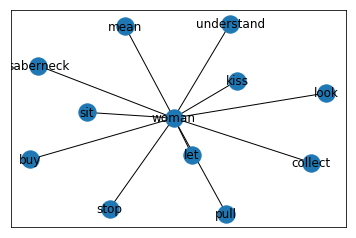

In [71]:
nx.draw_networkx(g_womanNV10)

In [85]:
g_girlNV10 = gNV_10s.subgraph(['girl'] + list(gNV_10s.neighbors('girl')))

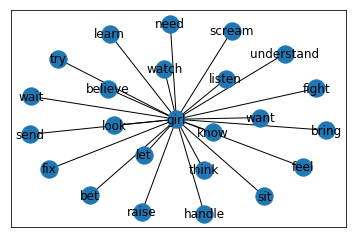

In [86]:
nx.draw_networkx(g_girlNV10)

In [72]:
g_manNV10 = gNV_10s.subgraph(['man'] + list(gNV_10s.neighbors('man')))

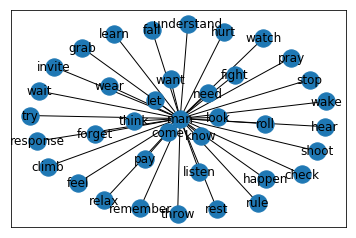

In [73]:
nx.draw_networkx(g_manNV10)

In [87]:
g_boyNV10 = gNV_10s.subgraph(['boy'] + list(gNV_10s.neighbors('boy')))

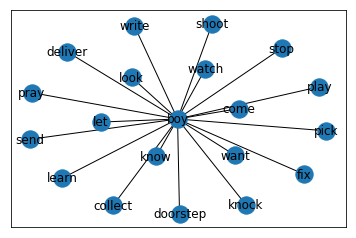

In [88]:
nx.draw_networkx(g_boyNV10)

In [74]:
sorted(nx.degree_centrality(g_manNV10).items(), key = lambda x: x[1], reverse = True)[:10]

[('man', 1.0),
 ('understand', 0.02702702702702703),
 ('response', 0.02702702702702703),
 ('feel', 0.02702702702702703),
 ('shoot', 0.02702702702702703),
 ('throw', 0.02702702702702703),
 ('wait', 0.02702702702702703),
 ('learn', 0.02702702702702703),
 ('fall', 0.02702702702702703),
 ('forget', 0.02702702702702703)]

In [75]:
sorted(nx.eigenvector_centrality(g_manNV10).items(), key = lambda x: x[1], reverse = True)[:10]

[('man', 0.7071050849987754),
 ('understand', 0.11624791759470243),
 ('response', 0.11624791759470243),
 ('feel', 0.11624791759470243),
 ('shoot', 0.11624791759470243),
 ('throw', 0.11624791759470243),
 ('wait', 0.11624791759470243),
 ('learn', 0.11624791759470243),
 ('fall', 0.11624791759470243),
 ('forget', 0.11624791759470243)]

In [76]:
sorted(nx.degree_centrality(g_womanNV10).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 1.0),
 ('stop', 0.09090909090909091),
 ('understand', 0.09090909090909091),
 ('saberneck', 0.09090909090909091),
 ('buy', 0.09090909090909091),
 ('collect', 0.09090909090909091),
 ('mean', 0.09090909090909091),
 ('let', 0.09090909090909091),
 ('sit', 0.09090909090909091),
 ('look', 0.09090909090909091)]

In [77]:
sorted(nx.eigenvector_centrality(g_womanNV10).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 0.7071075812704491),
 ('stop', 0.21320047512096454),
 ('understand', 0.21320047512096454),
 ('saberneck', 0.21320047512096454),
 ('buy', 0.21320047512096454),
 ('collect', 0.21320047512096454),
 ('mean', 0.21320047512096454),
 ('let', 0.21320047512096454),
 ('sit', 0.21320047512096454),
 ('look', 0.21320047512096454)]

In [78]:
wmnNeighbors = gNV_10s.neighbors('woman')
set(wmnNeighbors)

{'buy',
 'collect',
 'kiss',
 'let',
 'look',
 'mean',
 'pull',
 'saberneck',
 'sit',
 'stop',
 'understand'}

In [79]:
mnNeighbors = gNV_10s.neighbors('man')
set(mnNeighbors)

{'check',
 'climb',
 'come',
 'fall',
 'feel',
 'fight',
 'forget',
 'grab',
 'happen',
 'hear',
 'hurt',
 'invite',
 'know',
 'learn',
 'let',
 'listen',
 'look',
 'need',
 'pay',
 'pray',
 'relax',
 'remember',
 'response',
 'rest',
 'roll',
 'rule',
 'shoot',
 'stop',
 'think',
 'throw',
 'try',
 'understand',
 'wait',
 'wake',
 'want',
 'watch',
 'wear'}

# NOUN ADJECTIVE RELATIONSHIPS

# 1930 NJ Relationships

In [89]:
gNJ_30s = posCooccurrence(only30s_50['normalized_sents'].sum(), 'NN', 'JJ')

In [91]:
gNJ_30s.remove_edges_from([(n1,n2) for n1,n2,d in gNJ_30s.edges(data = True) if gNJ_30s.nodes[n1]['bipartite'] == gNJ_30s.nodes[n2]['bipartite']])

In [92]:
g_womanNJ30 = gNJ_30s.subgraph(['woman'] + list(gNJ_30s.neighbors('woman')))

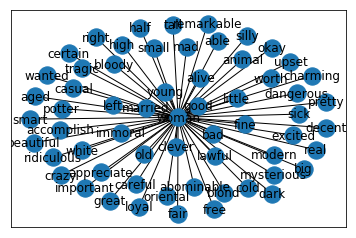

In [93]:
nx.draw_networkx(g_womanNJ30)

In [94]:
g_girlNJ30 = gNJ_30s.subgraph(['girl'] + list(gNJ_30s.neighbors('girl')))

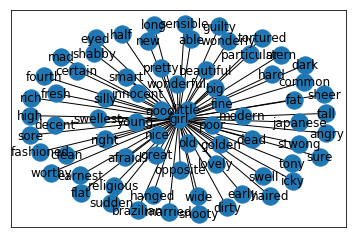

In [95]:
nx.draw_networkx(g_girlNJ30)

In [96]:
g_manNJ30 = gNJ_30s.subgraph(['man'] + list(gNJ_30s.neighbors('man')))

In [127]:
list(gNJ_30s.neighbors('man'))

['alive',
 'capable',
 'free',
 'mouthed',
 'devoted',
 'extraordinary',
 'icky',
 'wrong',
 'good',
 'double',
 'strange',
 'awful',
 'violent',
 'minded',
 'naughty',
 'present',
 'terrible',
 'broad',
 'young',
 'sick',
 'famous',
 'true',
 'right',
 'foul',
 'sentimental',
 'single',
 'prim',
 'rich',
 'favorite',
 'nice',
 'ugly',
 'filthy',
 'thoughtless',
 'poor',
 'wild',
 'busy',
 'tough',
 'entered',
 'fine',
 'dead',
 'crossed',
 'chinese',
 'sane',
 'happy',
 'guilty',
 'whitest',
 'real',
 'peaceful',
 'wet',
 'difficult',
 'quick',
 'sad',
 'sorry',
 'brave',
 'eternal',
 'ardent',
 'useful',
 'undercover',
 'bad',
 'clinical',
 'miniature',
 'long',
 'dear',
 'attractive',
 'little',
 'particular',
 'marvelous',
 'crazy',
 'certain',
 'dangerous',
 'pathological',
 'innocent',
 'funny',
 'engaged',
 'swipe',
 'changed',
 'dirty',
 'hurt',
 'live',
 'curious',
 'elustrous',
 'wish',
 'casual',
 'utmost',
 'decent',
 'close',
 'swellest',
 'mad',
 'charming',
 'legal',
 'p

In [129]:
man_nbr = list(gNJ_30s.neighbors('man'))

In [132]:
sorted(man_nbr, key = lambda x: x[1], reverse = True)[:10]

['extraordinary',
 'excited',
 'awful',
 'swipe',
 'swellest',
 'busy',
 'guilty',
 'quick',
 'funny',
 'hurt']

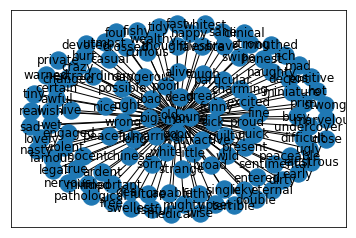

In [97]:
nx.draw_networkx(g_manNJ30)

In [98]:
g_boyNJ30 = gNJ_30s.subgraph(['boy'] + list(gNJ_30s.neighbors('boy')))

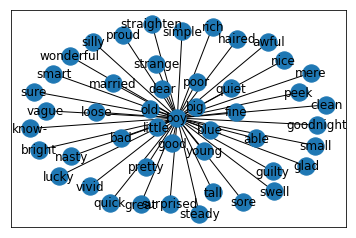

In [99]:
nx.draw_networkx(g_boyNJ30)

In [100]:
sorted(nx.degree_centrality(g_manNJ30).items(), key = lambda x: x[1], reverse = True)[:10]

[('man', 1.0),
 ('marvelous', 0.008264462809917356),
 ('ugly', 0.008264462809917356),
 ('crazy', 0.008264462809917356),
 ('alive', 0.008264462809917356),
 ('wet', 0.008264462809917356),
 ('positive', 0.008264462809917356),
 ('minded', 0.008264462809917356),
 ('favorite', 0.008264462809917356),
 ('clinical', 0.008264462809917356)]

In [101]:
sorted(nx.eigenvector_centrality(g_manNJ30).items(), key = lambda x: x[1], reverse = True)[:10]

[('man', 0.7071109838196059),
 ('marvelous', 0.06428205259350105),
 ('ugly', 0.06428205259350105),
 ('crazy', 0.06428205259350105),
 ('alive', 0.06428205259350105),
 ('wet', 0.06428205259350105),
 ('positive', 0.06428205259350105),
 ('minded', 0.06428205259350105),
 ('favorite', 0.06428205259350105),
 ('clinical', 0.06428205259350105)]

In [102]:
sorted(nx.degree_centrality(g_womanNJ30).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 1.0),
 ('great', 0.016666666666666666),
 ('left', 0.016666666666666666),
 ('smart', 0.016666666666666666),
 ('charming', 0.016666666666666666),
 ('crazy', 0.016666666666666666),
 ('alive', 0.016666666666666666),
 ('lawful', 0.016666666666666666),
 ('able', 0.016666666666666666),
 ('half', 0.016666666666666666)]

In [103]:
sorted(nx.eigenvector_centrality(g_womanNJ30).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 0.7071095153853593),
 ('great', 0.09128673993261388),
 ('left', 0.09128673993261388),
 ('smart', 0.09128673993261388),
 ('charming', 0.09128673993261388),
 ('crazy', 0.09128673993261388),
 ('alive', 0.09128673993261388),
 ('lawful', 0.09128673993261388),
 ('able', 0.09128673993261388),
 ('half', 0.09128673993261388)]

In [104]:
wmnNeighborsJ = gNJ_30s.neighbors('woman')
set(wmnNeighborsJ)

{'able',
 'abominable',
 'accomplish',
 'aged',
 'alive',
 'animal',
 'appreciate',
 'bad',
 'beautiful',
 'big',
 'blond',
 'bloody',
 'careful',
 'casual',
 'certain',
 'charming',
 'clever',
 'cold',
 'crazy',
 'dangerous',
 'dark',
 'decent',
 'excited',
 'fair',
 'fine',
 'free',
 'good',
 'great',
 'half',
 'high',
 'immoral',
 'important',
 'lawful',
 'left',
 'little',
 'loyal',
 'mad',
 'married',
 'modern',
 'mysterious',
 'okay',
 'old',
 'oriental',
 'potter',
 'pretty',
 'real',
 'remarkable',
 'ridiculous',
 'right',
 'sick',
 'silly',
 'small',
 'smart',
 'tall',
 'tragic',
 'upset',
 'wanted',
 'white',
 'worth',
 'young'}

In [105]:
mnNeighborsJ = gNJ_30s.neighbors('man')
set(mnNeighborsJ)

{'alive',
 'ardent',
 'attractive',
 'awful',
 'bad',
 'big',
 'brave',
 'broad',
 'busy',
 'capable',
 'casual',
 'certain',
 'changed',
 'charming',
 'chinese',
 'clinical',
 'close',
 'crazy',
 'crossed',
 'curious',
 'dangerous',
 'dead',
 'dear',
 'decent',
 'devoted',
 'difficult',
 'dirty',
 'double',
 'early',
 'elustrous',
 'engaged',
 'entered',
 'eternal',
 'excited',
 'extraordinary',
 'famous',
 'fast',
 'favorite',
 'filthy',
 'fine',
 'fishy',
 'foul',
 'free',
 'funny',
 'future',
 'good',
 'great',
 'guilty',
 'happy',
 'honest',
 'hot',
 'hurt',
 'icky',
 'important',
 'innocent',
 'legal',
 'little',
 'live',
 'long',
 'lovely',
 'mad',
 'married',
 'marvelous',
 'medical',
 'mighty',
 'minded',
 'miniature',
 'mouthed',
 'nasty',
 'naughty',
 'nervous',
 'nice',
 'old',
 'particular',
 'pathological',
 'peaceable',
 'peaceful',
 'poor',
 'positive',
 'possible',
 'present',
 'prim',
 'private',
 'proud',
 'quick',
 'real',
 'rich',
 'right',
 'sad',
 'sane',
 'senti

# 2010 NJ Relations

In [106]:
gNJ_10s = posCooccurrence(only10s_50['normalized_sents'].sum(), 'NN', 'JJ')

In [107]:
gNJ_10s.remove_edges_from([(n1,n2) for n1,n2,d in gNJ_10s.edges(data = True) if gNJ_10s.nodes[n1]['bipartite'] == gNJ_10s.nodes[n2]['bipartite']])

In [108]:
g_womanNJ10 = gNJ_10s.subgraph(['woman'] + list(gNJ_10s.neighbors('woman')))

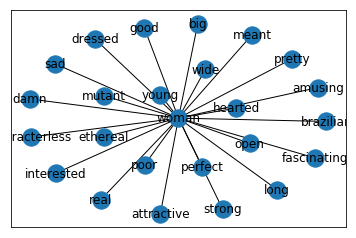

In [109]:
nx.draw_networkx(g_womanNJ10)

In [110]:
g_girlNJ10 = gNJ_10s.subgraph(['girl'] + list(gNJ_10s.neighbors('girl')))

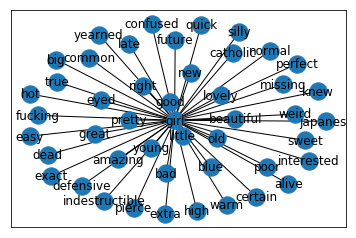

In [111]:
nx.draw_networkx(g_girlNJ10)

In [112]:
g_manNJ10 = gNJ_10s.subgraph(['man'] + list(gNJ_10s.neighbors('man')))

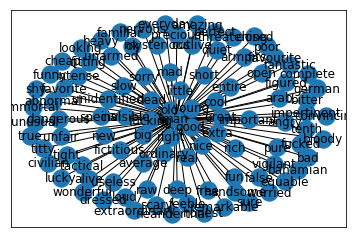

In [113]:
nx.draw_networkx(g_manNJ10)

In [114]:
g_boyNJ10 = gNJ_10s.subgraph(['boy'] + list(gNJ_10s.neighbors('boy')))

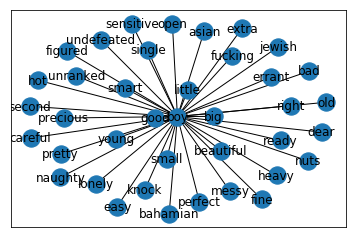

In [115]:
nx.draw_networkx(g_boyNJ10)

In [116]:
sorted(nx.degree_centrality(g_manNJ10).items(), key = lambda x: x[1], reverse = True)[:10]

[('man', 1.0),
 ('bitter', 0.010101010101010102),
 ('alive', 0.010101010101010102),
 ('favorite', 0.010101010101010102),
 ('true', 0.010101010101010102),
 ('sorry', 0.010101010101010102),
 ('cheap', 0.010101010101010102),
 ('worried', 0.010101010101010102),
 ('perfect', 0.010101010101010102),
 ('fantastic', 0.010101010101010102)]

In [117]:
sorted(nx.eigenvector_centrality(g_manNJ10).items(), key = lambda x: x[1], reverse = True)[:10]

[('man', 0.7071107072015742),
 ('bitter', 0.07106651087032304),
 ('alive', 0.07106651087032304),
 ('favorite', 0.07106651087032304),
 ('true', 0.07106651087032304),
 ('sorry', 0.07106651087032304),
 ('cheap', 0.07106651087032304),
 ('worried', 0.07106651087032304),
 ('perfect', 0.07106651087032304),
 ('fantastic', 0.07106651087032304)]

In [118]:
sorted(nx.degree_centrality(g_womanNJ10).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 1.0),
 ('open', 0.041666666666666664),
 ('dressed', 0.041666666666666664),
 ('fascinating', 0.041666666666666664),
 ('amusing', 0.041666666666666664),
 ('meant', 0.041666666666666664),
 ('characterless', 0.041666666666666664),
 ('strong', 0.041666666666666664),
 ('perfect', 0.041666666666666664),
 ('interested', 0.041666666666666664)]

In [119]:
sorted(nx.eigenvector_centrality(g_womanNJ10).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 0.7071080258578532),
 ('open', 0.14433731322949292),
 ('dressed', 0.14433731322949292),
 ('fascinating', 0.14433731322949292),
 ('amusing', 0.14433731322949292),
 ('meant', 0.14433731322949292),
 ('characterless', 0.14433731322949292),
 ('strong', 0.14433731322949292),
 ('perfect', 0.14433731322949292),
 ('interested', 0.14433731322949292)]

In [120]:
wmnNeighborsJ10 = gNJ_10s.neighbors('woman')
set(wmnNeighborsJ10)

{'amusing',
 'attractive',
 'big',
 'brazilian',
 'characterless',
 'damn',
 'dressed',
 'ethereal',
 'fascinating',
 'good',
 'hearted',
 'interested',
 'long',
 'meant',
 'mutant',
 'open',
 'perfect',
 'poor',
 'pretty',
 'real',
 'sad',
 'strong',
 'wide',
 'young'}

In [122]:
mnNeighborsJ10 = gNJ_10s.neighbors('man')
set(mnNeighborsJ10)

{'abnormal',
 'alive',
 'amazing',
 'angry',
 'arab',
 'armpits',
 'average',
 'bad',
 'bahamian',
 'big',
 'bitter',
 'bloody',
 'cheap',
 'civilian',
 'closed',
 'complete',
 'convincing',
 'cool',
 'dangerous',
 'dead',
 'deep',
 'dressed',
 'entire',
 'equable',
 'everyday',
 'extra',
 'extraordinary',
 'false',
 'familiar',
 'fantastic',
 'favorite',
 'favourite',
 'feeble',
 'fictitious',
 'figured',
 'fitting',
 'free',
 'fucked',
 'fucking',
 'fun',
 'funny',
 'german',
 'good',
 'great',
 'handsome',
 'heavy',
 'honest',
 'immortal',
 'impertinent',
 'important',
 'intense',
 'invisible',
 'little',
 'looking',
 'loud',
 'lucky',
 'mad',
 'mysterious',
 'neanderthal',
 'nervous',
 'new',
 'nice',
 'ok',
 'old',
 'open',
 'ordinary',
 'outlive',
 'perfect',
 'poor',
 'precious',
 'pure',
 'quiet',
 'raw',
 'real',
 'remarkable',
 'rich',
 'right',
 'scary',
 'short',
 'shy',
 'slow',
 'sorry',
 'special',
 'sure',
 'tactical',
 'tenth',
 'threatening',
 'tight',
 'titty',
 'tru

In [164]:
gNPOS_10s = posCooccurrence(only10s_50['normalized_sents'].sum(), 'NN', 'POS')

In [161]:
#gNPOS_10s.remove_edges_from([(n1,n2) for n1,n2,d in gNPOS_10s.edges(data = True) if gNPOS_10s.nodes[n1]['bipartite'] == gNPOS_10s.nodes[n2]['bipartite']])

In [165]:
g_womanNPOS10 = gNPOS_10s.subgraph(['woman'] + list(gNPOS_10s.neighbors('woman')))

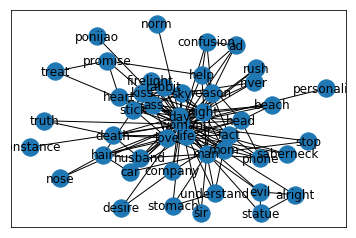

In [166]:
nx.draw_networkx(g_womanNPOS10)

In [167]:
sorted(nx.degree_centrality(g_womanNPOS10).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 1.0444444444444445),
 ('day', 0.48888888888888893),
 ('man', 0.4222222222222222),
 ('night', 0.37777777777777777),
 ('life', 0.35555555555555557),
 ('love', 0.35555555555555557),
 ('reason', 0.24444444444444446),
 ('mom', 0.24444444444444446),
 ('rabbit', 0.22222222222222224),
 ('head', 0.22222222222222224)]

In [168]:
g_manNPOS10 = gNPOS_10s.subgraph(['man'] + list(gNPOS_10s.neighbors('man')))

In [ ]:
gNPOS_10s.remove_edges_from([(n1,n2) for n1,n2,d in gNPOS_10s.edges(data = True) if gNPOS_10s.nodes[n1]['bipartite'] == gNPOS_10s.nodes[n2]['bipartite']])

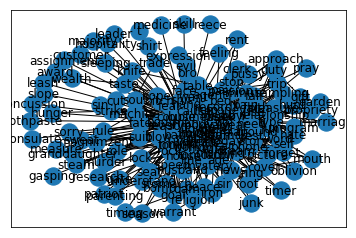

In [169]:
nx.draw_networkx(g_manNPOS10)

In [170]:
sorted(nx.degree_centrality(g_manNPOS10).items(), key = lambda x: x[1], reverse = True)[:10]

[('man', 1.0119760479041917),
 ('time', 0.44910179640718567),
 ('way', 0.32335329341317365),
 ('life', 0.28742514970059885),
 ('job', 0.251497005988024),
 ('love', 0.24550898203592816),
 ('thing', 0.23952095808383234),
 ('fire', 0.23353293413173654),
 ('place', 0.22754491017964074),
 ('night', 0.2155688622754491)]

In [171]:
g_girlNPOS10 = gNPOS_10s.subgraph(['girl'] + list(gNPOS_10s.neighbors('girl')))

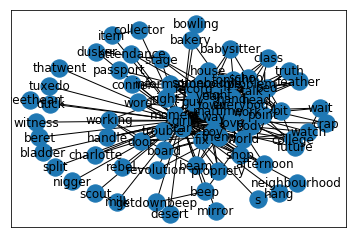

In [172]:
nx.draw_networkx(g_girlNPOS10)

In [173]:
sorted(nx.degree_centrality(g_girlNPOS10).items(), key = lambda x: x[1], reverse = True)[:10]

[('girl', 1.0246913580246912),
 ('time', 0.48148148148148145),
 ('way', 0.2962962962962963),
 ('work', 0.2962962962962963),
 ('night', 0.2839506172839506),
 ('man', 0.2716049382716049),
 ('friend', 0.2345679012345679),
 ('town', 0.2345679012345679),
 ('everybody', 0.20987654320987653),
 ('love', 0.20987654320987653)]

In [134]:
gNPOS_30s = posCooccurrence(only10s_50['normalized_sents'].sum(), 'NN', 'POS')

In [174]:
g_womanNPOS30 = gNPOS_30s.subgraph(['woman'] + list(gNPOS_30s.neighbors('woman')))

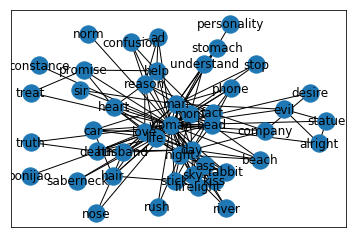

In [175]:
nx.draw_networkx(g_womanNPOS30)

In [176]:
sorted(nx.degree_centrality(g_womanNPOS30).items(), key = lambda x: x[1], reverse = True)[:10]

[('woman', 1.0444444444444445),
 ('day', 0.48888888888888893),
 ('man', 0.4222222222222222),
 ('night', 0.37777777777777777),
 ('life', 0.35555555555555557),
 ('love', 0.35555555555555557),
 ('reason', 0.24444444444444446),
 ('mom', 0.24444444444444446),
 ('rabbit', 0.22222222222222224),
 ('head', 0.22222222222222224)]

In [135]:
movie_metadata = pd.read_csv(r'\Users\iarak\OneDrive\Desktop\CCA\imdb-5000-movie-dataset\movie_metadata.csv')

In [136]:
movie_metadata.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [141]:
movie_metadata.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [148]:
movie_metadata.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [154]:
movie_metadata['movie_title']

0                                                 Avatar 
1               Pirates of the Caribbean: At World's End 
2                                                Spectre 
3                                  The Dark Knight Rises 
4       Star Wars: Episode VII - The Force Awakens    ...
                              ...                        
5038                             Signed Sealed Delivered 
5039                           The Following             
5040                                A Plague So Pleasant 
5041                                    Shanghai Calling 
5042                                   My Date with Drew 
Name: movie_title, Length: 5043, dtype: object

In [143]:
mask = ((movie_metadata['title_year'] >= 1930) &
        (movie_metadata['title_year'] <= 2017) 
        )

In [155]:
masked = movie_metadata[mask]

In [157]:
masked.count()

color                        4914
director_name                4929
num_critic_for_reviews       4888
duration                     4917
director_facebook_likes      4929
actor_3_facebook_likes       4911
actor_2_name                 4919
actor_1_facebook_likes       4922
gross                        4152
genres                       4929
actor_1_name                 4922
movie_title                  4929
num_voted_users              4929
cast_total_facebook_likes    4929
actor_3_name                 4911
facenumber_in_poster         4916
plot_keywords                4789
movie_imdb_link              4929
num_user_for_reviews         4914
language                     4923
country                      4928
content_rating               4669
budget                       4538
title_year                   4929
actor_2_facebook_likes       4919
imdb_score                   4929
aspect_ratio                 4622
movie_facebook_likes         4929
dtype: int64

In [151]:
titles = movie_metadata[mask].merge(movdf_norm, left_on='movie_title', right_on = 'Movie Name')
#titles = titles.merge(title_ratings_df, on='tconst')

KeyError: 'movie_title'

In [153]:
movie_metadata.merge(movdf_norm, left_on='movie_title', right_on = 'Movie Name', how = 'inner')

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,Genre,Year,Country,IMDb,Tokenized,Text,word_count,normalized_tokens,tokenized_sents,normalized_sents


In [ ]:
title_basics_df = pd.read_csv('title.basics.tsv.gz', sep='\t')
title_cast_df = pd.read_csv('title.principals.tsv.gz', sep='\t')
title_ratings_df = pd.read_csv('title.ratings.tsv.gz', sep='\t')

C:\Users\iarak\Anaconda3\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
## Helper Functions
def clean_year(y):
    # Return year as an integer or 'NaN' if empty
    import numpy as np
    try:
        return int(y)
    except:
        return np.nan

def clean_genre(y):
    # Return only the first genre listed
    y = str(y)
    if y == '\\N':
        return ''
    return y.split(',')[0].strip()

title_basics_df.drop('endYear', axis=1, inplace=True)
title_basics_df['startYear'] = title_basics_df['startYear'].apply(clean_year)
title_basics_df['runtimeMinutes'] = title_basics_df['runtimeMinutes'].apply(clean_year)
title_basics_df['genres'] = title_basics_df['genres'].apply(clean_genre)
title_basics_df.dropna(inplace=True, how='any', subset=['startYear', 'runtimeMinutes'])

In [ ]:
mask = ((title_basics_df['startYear'] >= 1930) &
        (title_basics_df['startYear'] <= 2017) &
        (title_basics_df['titleType'] == 'movie') &
        (title_basics_df['isAdult'] == 0) & 
        (title_basics_df['runtimeMinutes'] > 80) &
        (title_basics_df['genres'] != ''))

In [ ]:
titles = title_basics_df[mask].merge(title_cast_df, on='tconst')
titles = titles.merge(title_ratings_df, on='tconst')

In [ ]:
import pickle
with open('my_data.pkl', 'wb') as picklefile:
   pickle.dump(titles['tconst'].values, picklefile)